# Challenge 6

In this challenge, we will practice _feature engineering_, one of the most important and laborious processes of ML. We will use the _data set_ [Countries of the world] (https://www.kaggle.com/fernandol/countries-of-the-world), which contains data on the 227 countries in the world with information on population size, area, immigration and production sectors.

> Note: Please do not change the name of the response functions.

## _Setup_ geral

In [248]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)

In [249]:
from IPython.core.pylabtools import figsize

figsize(12, 8)

sns.set()

In [250]:
countries = pd.read_csv("countries.csv")

In [251]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

Country                               Region  Population     Area  \
0     Afghanistan         ASIA (EX. NEAR EAST)             31056997   647500   
1         Albania   EASTERN EUROPE                          3581655    28748   
2         Algeria   NORTHERN AFRICA                        32930091  2381740   
3  American Samoa   OCEANIA                                   57794      199   
4         Andorra   WESTERN EUROPE                            71201      468   

  Pop_density Coastline_ratio Net_migration Infant_mortality      GDP  \
0        48,0            0,00         23,06           163,07    700.0   
1       124,6            1,26         -4,93            21,52   4500.0   
2        13,8            0,04         -0,39               31   6000.0   
3       290,4           58,29        -20,71             9,27   8000.0   
4       152,1            0,00           6,6             4,05  19000.0   

  Literacy Phones_per_1000 Arable Crops  Other Climate Birthrate Deathrate  \
0     36,0             3,2  12,13  0,22  87,65       1      46,6     20,34   
1     86,5            71,2  21,09  4,42  74,49       3     15,11      5,22   
2     70,0            78,1   3,22  0,25  96,53       1     17,14      4,61   
3     97,0           259,5     10    15     75       2     22,46      3,27   
4    100,0           497,2   2,22     0  97,78       3      8,71      6,25   

  Agriculture Industry Service  
0        0,38     0,24    0,38  
1       0,232    0,188   0,579  
2       0,101      0,6   0,298  
3         NaN      NaN     NaN  
4         NaN      NaN     NaN

# Comments
This data set still needs some initial adjustments. First, note that numeric variables are using a comma as a decimal separator and are encoded as strings. Correct this before proceeding: make these variables numeric accordingly.

In addition, the Country and Region variables have extra spaces at the beginning and end of the string. You can use the str.strip () method to remove these spaces.

# Creating a FeaturesMagic class

I created this class in order to support the solution of the issues, thinking about reusability, modularization, code encapsulation and abstraction of several procedures.

In [304]:
class FeaturesMagic(object):
    """
    this class was developed to create, modify and makes features become awesome for future analysis.
    """
    
    def __init__(self, df):
        
        self.df = df.copy()
        # The definition of the specific pipeline can be kept here or maybe, be abstracted to another class in order to
        # organize the code and modify it easily.
        self.pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('standardization', StandardScaler())])

    def change_char(self, column_name, from_char, to_char, update_df=False):
        """
        Method used to replace characters in a string columns.
        
        args:
            column_name: column name to change characters.
            from_char: character to be changed.
            to_char: character to be inserted.
            update_df: if True, self.df will be updated if False self.df will not be updated
            
        return:
            changed_column: pd.series containing the column with the characters exchanged
        """
        
        changed_column = self.df[column_name].str.replace(from_char, to_char)
        
        if update_df:
            
            self.df[column_name] = changed_column
        
        return changed_column
    
    def convert_to_numeric(self, column_name, update_df=False):
        """
        Method used to convert columns to numeric columns.
        
        args:
            column_name: name of column to be changed.
            update_df: if True, self.df will be updated if False self.df will not be updated
            
        return:
            changed_column: pd.series with numerical column.
        """
        
        changed_column = pd.to_numeric(self.df[column_name])
        
        if update_df:
            
            self.df[column_name] = changed_column
           
        return changed_column
            
    def remove_extra_space(self, column_name, update_df=False):
        """
        Method used to remove extra space from entries of a given column.
        
        args:
            column_name: name of column to be spaces removed.
            update_df: if True, self.df will be updated if False self.df will not be updated
            
        return:
            changed_column: pd.series with entries without extra spaces.
        """
        
        changed_column = self.df[column_name].str.strip()
        if  update_df:
            
            self.df[column_name] = changed_column
            
        
        return changed_column
        
    def kbins_discretizer(self, column, n_bins, encode, strategy):
        """
        Method used to divide column values into specific ranges using K Bins Discretizer method. 
        
        args:
            column: name of column to apply the method.
            n_bins: number of divisions.
            encode: Method used to encode the transformed result.
                    onehot
                        Encode the transformed result with one-hot encoding
                        and return a sparse matrix. Ignored features are always
                        stacked to the right.
                    onehot-dense
                        Encode the transformed result with one-hot encoding
                        and return a dense array. Ignored features are always
                        stacked to the right.
                    ordinal
                        Return the bin identifier encoded as an integer value.
            strategy : {'uniform', 'quantile', 'kmeans'}, (default='quantile') Strategy used to define the widths of the bins.

                    uniform
                        All bins in each feature have identical widths.
                    quantile
                        All bins in each feature have the same number of points.
                    kmeans
                        Values in each bin have the same nearest center of a 1D k-means
                        cluster.
            
        return:
            score: Values of each associated bin
            bin_edges: The edges of each bin.
        """
        
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        discretizer.fit(self.df[[column]])
        score = discretizer.transform(self.df[[column]])[:, 0]
        bin_edges = discretizer.bin_edges_[0]
        
        return score, bin_edges
    
    def one_hot_encoder(self, column, sparse, dtype, update_df=False):
        """
        Method used to remove extra space from entries of a given column.
        
        args:
            column: name of column to apply the method.
            sparse: if True, return a sparse matrix if False, return a completely filled matrix.
            dtype: data structure used into new columns.
            
        return:
            encoded_values: matrix with correlation between original values and encoded values.
            encoded_columns:name of columns created by one_hot_encoder method.
        """
        one_hot_encoder = OneHotEncoder(sparse=sparse, dtype=dtype)
        encoded_values = one_hot_encoder.fit_transform(self.df[[column]].fillna('nan'))
        encoded_columns = one_hot_encoder.categories_[0]
        
        if update_df:
            
            self.df = pd.concat([self.df, pd.DataFrame(encoded_values, columns=encoded_columns)], axis=1)
        
        return encoded_values, encoded_columns
        
    def pipeline_fit(self, columns):
        """
        Method used to fit the pipeline with data.
        
        args:
            columns: single column or list of columns to fit the model following the defined pipeline
            
        return:
            self.pipeline: return the fitted pipeline object.
        """
        
        self.pipeline.fit(self.df[columns])
        print('Pipeline was fitted...')
        return self.pipeline
    
    def pipeline_transform(self, data):
        """
        Method used to tranform data using the defined pipeline.
        
        args:
            data: data frame to apply the transformation.
            
        return:
            columns_tranformed: updated values with the transformation.
        """
        columns_transformed = self.pipeline.transform(data)
        print('Data was transformed...')
        return columns_transformed
        

In [305]:
# instancing a FeaturesMagic object
feat = FeaturesMagic(countries)

In [306]:
# Feature treatment using the FeaturesMagic Class
# Replace , for . and transform to numerical values

# Define columns to modify.
columns_to_convert = ['Pop_density', 'Coastline_ratio', 'Net_migration', 'Infant_mortality', 'Literacy', 'Phones_per_1000',
                     'Arable', 'Crops', 'Other', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']

# Change char and convert to numerical columns using FeaturesMagic methods.
for column in columns_to_convert:

    feat.change_char(column, ',', '.', update_df=True)
    feat.convert_to_numeric(column, update_df=True)

# Define columns to extract extra spaces
columns_to_remove_spaces = ['Region', 'Country']

# Remove extra spaces.
for column in columns_to_remove_spaces:
    
    feat.remove_extra_space(column, update_df=True)

## Question 1

What are the regions (variable `Region`) present in the _data set_? Return a list with the unique regions of the _data set_ with the spaces in front and behind the string removed (but keep punctuation: period, hyphen etc) and sorted in alphabetical order.

In [307]:
def q1():
    # After remove extra spaces from Region column, just apply a method to get unique values, get the index and sort it
    # To finish converto to list just to answer the question in a right way.
    return feat.df['Region'].value_counts().index.sort_values().tolist()

## Question 2

Discretizing the variable `Pop_density` in 10 intervals with` KBinsDiscretizer`, following the encode `ordinal` and strategy` quantile`, how many countries are above the 90th percentile? Respond as a single integer scalar.

In [308]:
def q2():
    # To calculate how many countries are above 90° percentil we just have to calculate the number of True statment when
    # score equals the maximun value.
    score, bin_edges = feat.kbins_discretizer('Pop_density', n_bins=10, encode='ordinal', strategy='quantile')
    return sum(score == score.max())

# Question 3

If we code the `Region` and` Climate` variables using _one-hot encoding_, how many new attributes would be created? Respond as a single scalar.

In [309]:
def q3():
    # After apply the one hot encoder method, to know how many features will be included, just sum the number of columns
    # from "Region" and "Climate" results.
    region_encoded_values, region_encoded_columns = feat.one_hot_encoder('Region', False, np.int, False)
    climate_encoded_values, climate_encoded_columns = feat.one_hot_encoder('Climate', False, np.int, False)
    return region_encoded_values.shape[1] + climate_encoded_values.shape[1]

## Question 4

Apply the following _pipeline_:

1. Fill in the variables of type `int64` and` float64` with their respective medians.
2. Standardize these variables.

After applying the _pipeline_ described above to the data (only for variables of the specified types), apply the same _pipeline_ (or `ColumnTransformer`) to the data below. What is the value of the variable `Arable` after _pipeline_? Respond as a single float rounded to three decimal places.

In [310]:
test_country = [[
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]]

In [311]:
# get numerical columns from feat.df (countries).
numerical_columns = feat.df.dtypes[feat.df.dtypes != 'object'].index.tolist()

#Fitting the pipeline with feat.df values
feat.pipeline_fit(numerical_columns)

# Create DataFrame from new country data
new_country = pd.DataFrame(data=np.array(test_country), columns=feat.df.columns.tolist())

# Create a DataFrame with transformed data.
new_country_transf = feat.pipeline_transform(new_country[numerical_columns])
new_country_transf = pd.DataFrame(new_country_transf, columns=numerical_columns)

Pipeline was fitted...
Data was transformed...


In [312]:
def q4():
    # Choose to use .loc just to get the value from new country 'Arable' column
    return new_country_transf.loc[0, 'Arable'].round(3)
    pass

## Question 5


Find out the number of _outliers_ of the `Net_migration` variable according to the _boxplot_ method, that is, using logic:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ is outlier}$$

that are in the lower group and the upper group.

Should you remove comments considered _outliers_ according to this method from analysis? Respond as a three element tuple `(outliers_above, outliers_above, would you remove?)` ((Int, int, bool)).

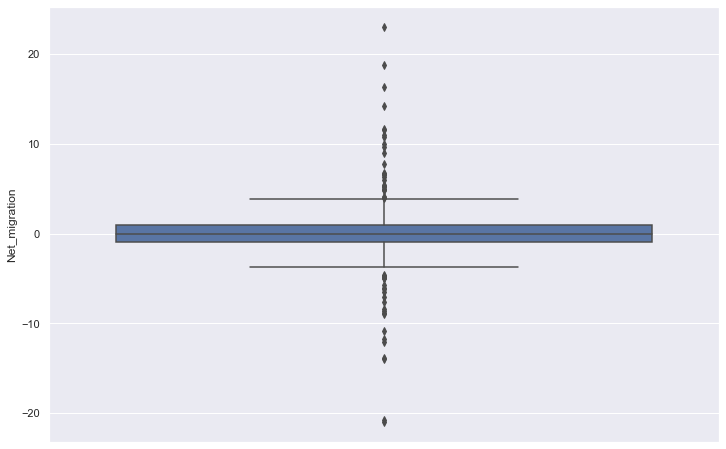

In [314]:
net_migration = feat.df['Net_migration']
sns.boxplot(net_migration, orient='vertical');

In [315]:
q_025 = net_migration.quantile(0.25)
q_075 = net_migration.quantile(0.75)
iqr = q_075 - q_025

non_outlier_interval_iqr = [q_025 - 1.5  * iqr, q_075 + 1.5 * iqr]
print(f"Faixa considerada \"normal\": {non_outlier_interval_iqr}")

outliers_below = net_migration[(net_migration < non_outlier_interval_iqr[0])]
outliers_above = net_migration[(net_migration > non_outlier_interval_iqr[1])]

n_outliers = outliers_below.count() + outliers_above.count()
n_net_migration = net_migration.count()

print('% of outliers = {}%'.format((n_outliers / n_net_migration).round(4) * 100))

Faixa considerada "normal": [-3.8149999999999995, 3.885]
% of outliers = 22.32%


Only with iqr analysis and not knowing for sure what the natural limits for the 'net_migration' variable would be, I would not remove outliers for now.

In [316]:
def q5():
    return outliers_below.count(), outliers_above.count(), False
    

## Question 6

For questions 6 and 7 use the `fetch_20newsgroups` library of` sklearn` test datasets

Consider uploading the following categories and the `newsgroups` dataset:

``
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups (subset = "train", categories = categories, shuffle = True, random_state = 42)
``


Apply `CountVectorizer` to the _data set_` newsgroups` and find out the number of times the word _phone_ appears in the corpus. Respond as a single scalar.

In [317]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [318]:
count_vectorizer = CountVectorizer()
newsgroups_counts = count_vectorizer.fit_transform(newsgroup.data)

words_frequence_df = pd.DataFrame(newsgroups_counts.toarray(), columns=np.array(count_vectorizer.get_feature_names()))

count_phone = words_frequence_df['phone'].sum()

In [319]:
def q6():
    return count_phone

## Question 7

Apply `TfidfVectorizer` to the _data set_` newsgroups` and discover the TF-IDF of the word _phone_. Respond as a single scalar rounded to three decimal places.

In [320]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(newsgroup.data)

newsgroup_tfidf_vectorized = tfidf_vectorizer.transform(newsgroup.data)
newsgroup_tfidf_df = pd.DataFrame(newsgroup_tfidf_vectorized.toarray(), columns=np.array(count_vectorizer.get_feature_names()))

tf_idf_phone = newsgroup_tfidf_df['phone']
total_tf_idf_phone = tf_idf_phone.sum().round(3)

In [321]:
def q7():
    return total_tf_idf_phone